# Sequential Bayesian Estimation

Consider observations arriving sequentially $Z_1, \ldots, Z_t$ from which we wish to estimate some unknown variable $X$, which is constant over time. Assume that we have a prior $P(X)$. Our goal is to compute $P(X|Z_1,\ldots,Z_t) = P(X|Z_{1:t})$ at every new step $t$:

\begin{align*}
bel_t(X) = P(X|Z_{1:t}) &= \frac{P(Z_{t}|X,Z_{1:t-1})P(X|Z_{1:t-1})}{P(Z_t|Z_{1:t-1})} \\
& = \eta\, P(Z_t|X)\,bel_{t-1}(X) 
\end{align*}

the above expression assumes that the sequential observations $Z$ are independent of each other. Therefore, $P(Z_{t}|X,Z_{1:t-1}) = P(Z_t|X)$. Note that $\eta$ is a normalization constant.

## Example: Is the door open?

Let's say that a sensor is measuring whether a door is open or closed continuously, so $X$ can be open or closed. Let's make the prior $P(X)$ uniform, so that $P(X = open) = 0.5$ and $P(X = closed) = 0.5$. Let's also assume that the sensor is noisy. It is more reliable at detecting closed doors than open doors:

\begin{align*}
&P(Z = open\, | X = open) = 0.6\\
&P(Z = closed\, | X = open) = 0.4\\
&P(Z = open\, | X = closed) = 0.2\\
&P(Z = closed\, | X = closed) = 0.8
\end{align*}

When the unknown variable $X$ is discrete, the recursive update $bel_t(X) = \eta\, P(Z_t | X)\, bel_{t-1}(X)$ corresponds to a discrete Bayes filter with no prediction function (see the [Prob. Robotics](http://www.probabilistic-robotics.org/) book, Table 4.1, pp. 87). Let `k = {open, closed}` so that `px_k` corresponds to $P(X = k)$. Then, this algorithm can be expressed as:

```python
recursive_estimate({px_k}, z_t):
    # compute unnormalized probs
    for all k:
        tmp_k = p(z_t | x_k) px_k
    # compute normalization factor
    eta = 1/sum({tmp_k})
    # compute normalized probs
    for all k:
        pk_k = tmp_k * eta
    # return all probs
    return {px_k}
```

How well can we estimate that the door is open in practice? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_obs = 100
n, p = 1, .6  # n = coins flipped, p = prob of success (assuming the door is open)
obs = np.random.binomial(n, p, num_obs) # observations
print(f"Observations:\n{obs}")
# print(f"Mean obs: {np.mean(obs)}")

prob_open = [0.5]  # prior for the door being open
obs_prob = np.array([[0.8, 0.2],  # rows refer to x value (row = 0 is x = closed; row =1 is x = open)
                     [0.4, 0.6]])

for t in range(num_obs):
    # first, compute P(obs|x=closed) P(x=closed)
    p_closed = obs_prob[0,obs[t]]*(1.0 - prob_open[t])
    # second, compute P(obs|x=open) P(x=open)
    p_open = obs_prob[1,obs[t]]*prob_open[t]
    # third, compute normalization factor
    eta = 1.0/(p_open + p_closed)
    # finally, save normalized new estimate: P(x=open|obs) = \eta P(obs|x=open) P(x=open)
    # note that we don't save P(x=closed|obs) because P(x=open|obs) = 1 - P(x=open|obs)
    p_open = p_open * eta
    prob_open.append(p_open) # store normalized prob of open

plt.plot(range(len(prob_open)), prob_open)
plt.ylim(0,1.02)
plt.xlim(-2,num_obs+2)
plt.grid(True)
plt.title("Prob of door being open")
plt.xlabel("t")
plt.show()

Observations:
[0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1
 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1
 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1]


Note that the above algorithm corresponds to a _binary Bayes filter with static state_ as in Section 4.2 of the [Prob. Robotics](http://www.probabilistic-robotics.org/) book. This type of filter is often used for estimating occupancy grids from robot observations. These grids are a matrix of [0,1] values indicating if a given space is free for a robot to navigate through. In practice, occupancy map estimation is done with the log odds ratio: $l(X) = \log (P(X) / P(\neg X))$. This corresponds to:

```python
recursive_estimate(lx, z_t):
    newlx = lx + log p(x|z_t) / (1 - p(x|z_t) - log p(x) / (1 - p(x))
    return newlx
```

The prob. `p(x|z_t)` in the second term `log p(x|z_t) / (1 - p(x|z_t)` is known as the `inverse sensor model`. For a derivation of the above algorithm, see [these slides from Intro. to Mobile Robotics](http://ais.informatik.uni-freiburg.de/teaching/ss16/robotics/slides/12-occupancy-mapping.pdf) by Wolfram Burgard.

Inverse model:
[[0.66666667 0.33333333]
 [0.25       0.75      ]]


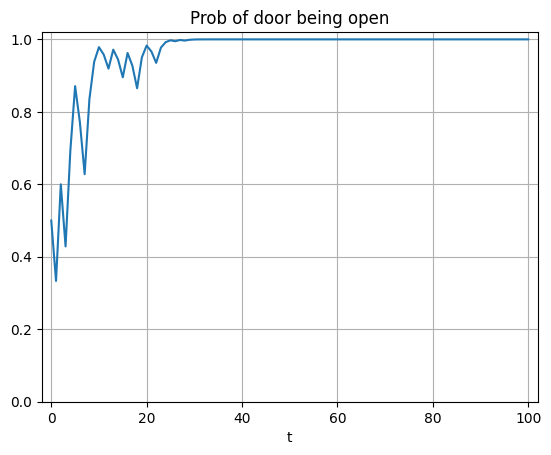

Difference in estimation: 1.6513984380676657e-15


In [3]:
# let's compare how the log-odds representation does vs. the implementation above. We use the same obsevations...

# compute the inverse sensor model
# because of the above probabilities, we have:
# p(z=open) = \sum_x p(z=open|x)p(x) = 0.6x0.5 + 0.2x0.5 = 0.4
# p(z=closed) = \sum_x p(z=closed|x)p(x) = 0.4x0.5 + 0.8x0.5 = 0.6

# p(x|z_t) = p(z_t | x)p(x) / p(z_t)
inv_obs_prob = np.zeros((2,2))
# p(x = closed | z_t = closed) 
inv_obs_prob[0,0] = obs_prob[0,0]*(1 - prob_open[0])/0.6 
# p(x = open | z_t = closed) 
inv_obs_prob[0,1] = obs_prob[1,0]*(prob_open[0]) /0.6
#inv_obs_prob[0,:] = inv_obs_prob[0,:] / sum(inv_obs_prob[0,:])
# p(x = closed | z_t = open) 
inv_obs_prob[1,0] = obs_prob[0,1]*(1 - prob_open[0]) /0.4
# p(x = open | z_t = open) 
inv_obs_prob[1,1] = obs_prob[1,1]*(prob_open[0]) /0.4
#inv_obs_prob[1,:] = inv_obs_prob[1,:] / sum(inv_obs_prob[1,:])
print(f"Inverse model:\n{inv_obs_prob}")

# note that this is the same calculation as if we had normalized inv_obs_prob per row...
# uncomment the block below to compare
# inv_obs_prob = np.zeros((2,2))
# inv_obs_prob[0,0] = obs_prob[0,0]*(1 - prob_open[0])
# inv_obs_prob[0,1] = obs_prob[1,0]*(prob_open[0]) 
# inv_obs_prob[0,:] = inv_obs_prob[0,:] / sum(inv_obs_prob[0,:])
# inv_obs_prob[1,0] = obs_prob[0,1]*(1 - prob_open[0])
# inv_obs_prob[1,1] = obs_prob[1,1]*(prob_open[0]) 
# inv_obs_prob[1,:] = inv_obs_prob[1,:] / sum(inv_obs_prob[1,:])
# print(inv_obs_prob)

log_odds = [np.log(prob_open[0]/(1 - prob_open[0]))]  # log odds for the door being open: log p(x)/(1 - p(x))
prior_term = log_odds[0]

for t in range(num_obs):
    # first, compute term based on inverse sensor model: log p(x|z)/(1 - p(x|z))
    pxz = inv_obs_prob[obs[t],1]
    inv_term = np.log(pxz/(1-pxz))
    l = log_odds[t] + inv_term - prior_term  # see table 4.2 in the prob. robotics book for the derivation of this formula
    log_odds.append(l) # store normalized prob of open

# convert log odds to prob
prob_open_from_odds = [1 - 1/(1 + np.exp(l)) for l in log_odds]

plt.plot(range(len(prob_open_from_odds)), prob_open_from_odds)
plt.ylim(0,1.02)
plt.xlim(-2,num_obs+2)
plt.grid(True)
plt.title("Prob of door being open")
plt.xlabel("t")
plt.show()

# how different are the new probs from before?
print(f"Difference in estimation: {np.linalg.norm(np.array(prob_open_from_odds) - np.array(prob_open))}")

# Non-Parametric Estimation

Another way to represent the distribution of $X$ is through samples: $X := \{x^{[1]}, \ldots, x^{[M]}\}$. Each particle $x^{[m]}$ is a concrete instantiation of the unknown $X$, $x^{[m]} \sim bel_t(X) = P(X|Z_{1:t})$. 

Assume that the set of particles $X_{t-1}$ approximate $bel_{t-1}(X)$. Then, we can use importance sampling to approximate the new belief $bel_{t}(X)$, where the weight of a new particle is $w_t^{[m]} = \eta P(Z_t|X_t)$ and $\eta$ is a normalization constant -- see Sec. 4.3.3 of the [Prob. Robotics](http://www.probabilistic-robotics.org/) book for the derivation of the particle filter, which applies in this case ignoring the update step. In brief, importance sampling resamples the particles with probability proportional to $w_t^{[m]}$:

```python
recursive_estimate({x^1, ..., x^m}, z_t):
    W = [] # weights set
    X = [] # resampled set
    
    # compute weights
    for m = 1 to M:
        w^m = P(z_t | x^m)
        W.append(w^m)
                 
    # resampling
    for m = 1 to M:
        draw i with probability prop. to w^m
        X.append(x^i)

    # return resampled set of particles
    return X
```

Note that the above procedure is prone to loosing particle diversity: over time, M identical copies of a single particle will survive. The [Prob. Robotics](http://www.probabilistic-robotics.org/) book (sec. 4.3.4 on "Resampling") suggests never resampling when the state is known to be static and integrating observations via multiplicatively updating the importance factor. This approach is implemented below for the door example.

Estimated prob. door is open: 0.7777777777777779


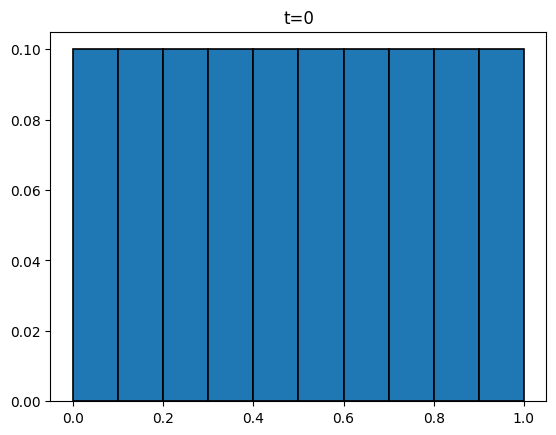

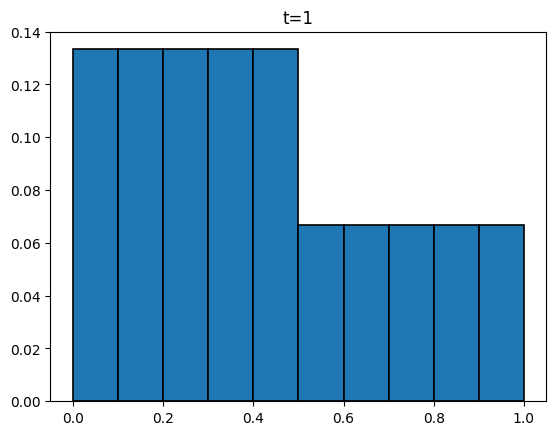

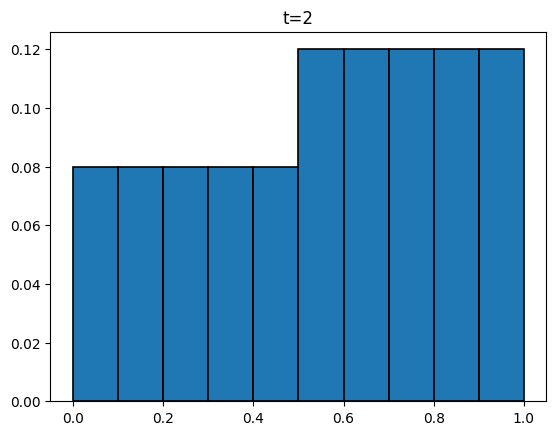

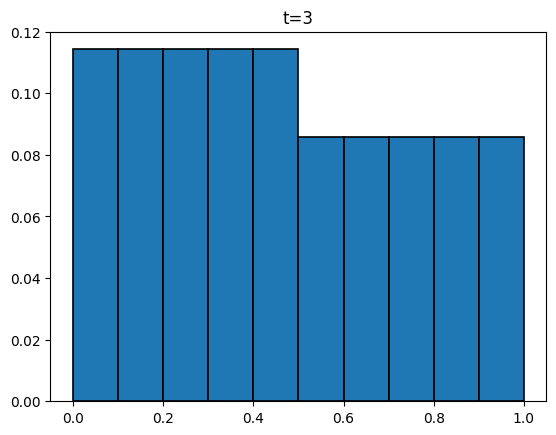

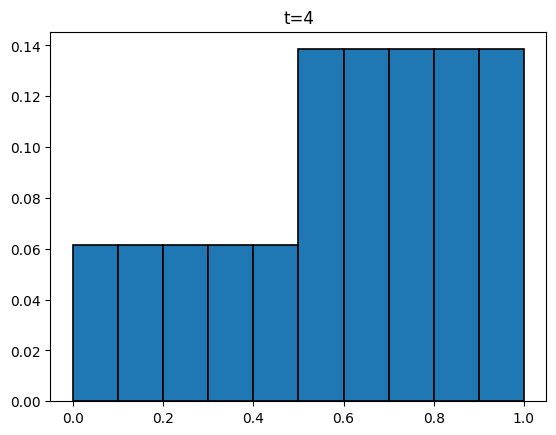

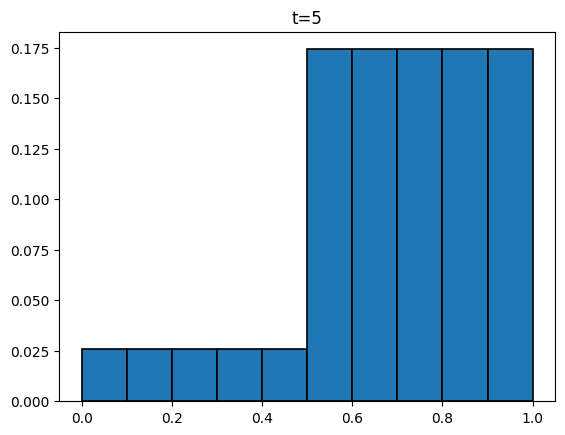

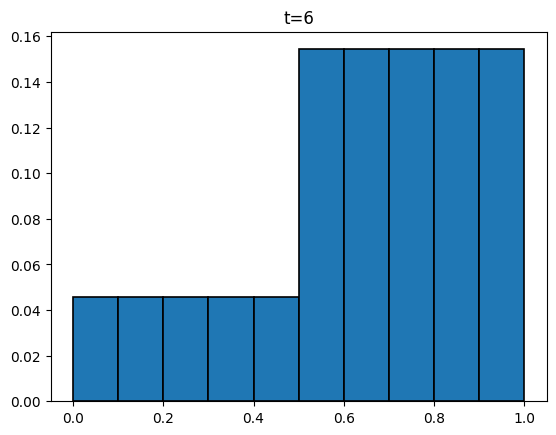

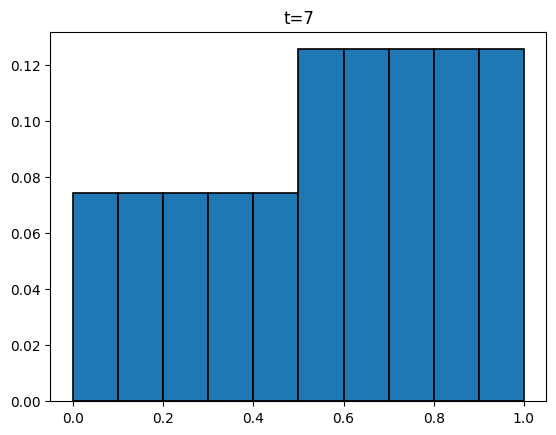

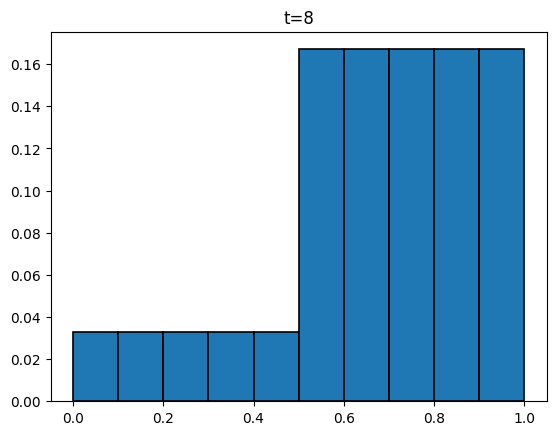

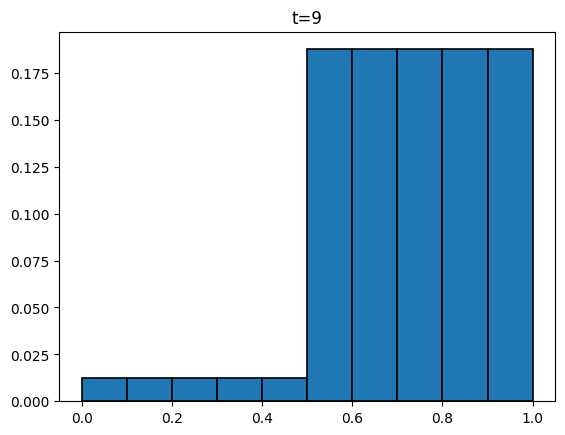

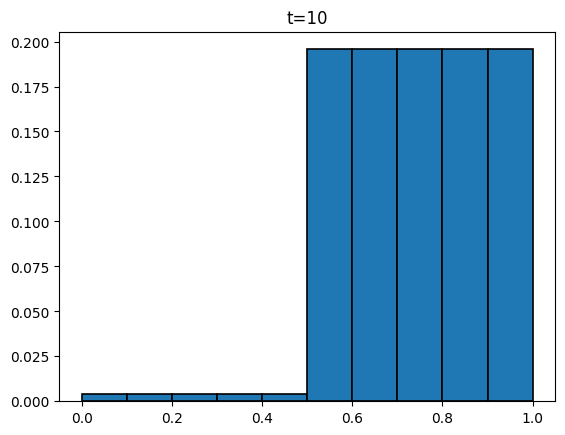

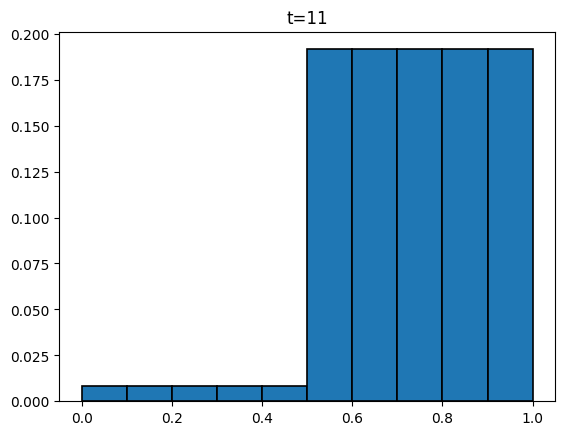

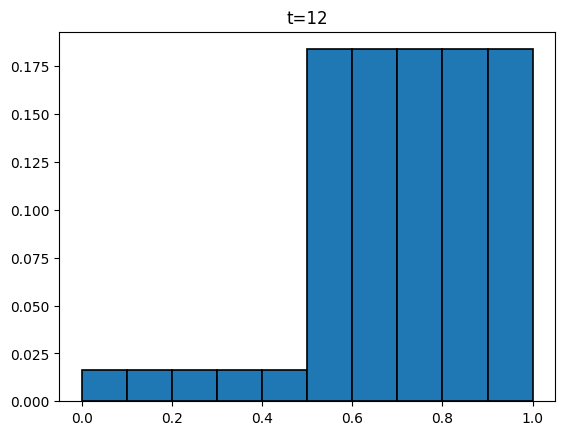

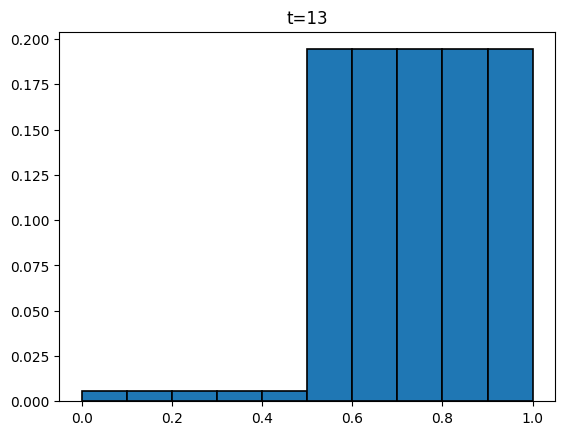

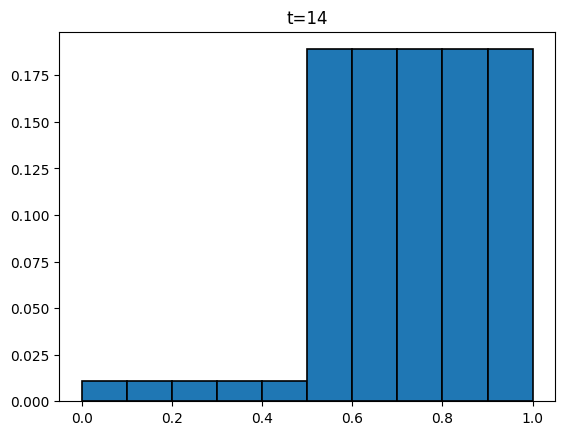

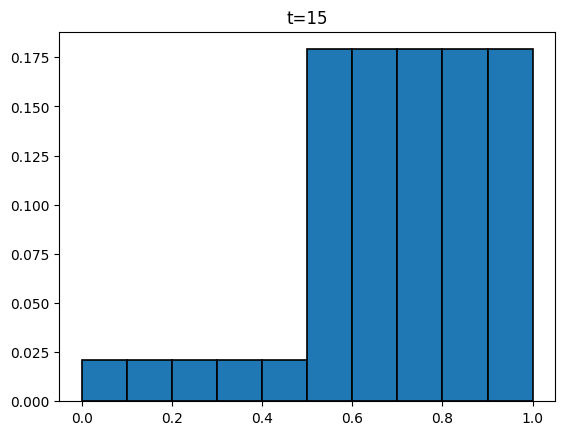

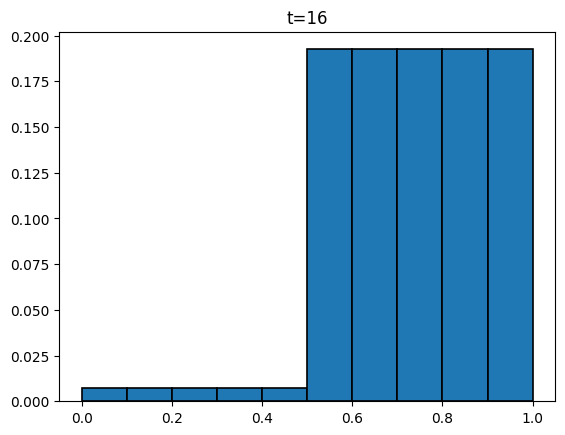

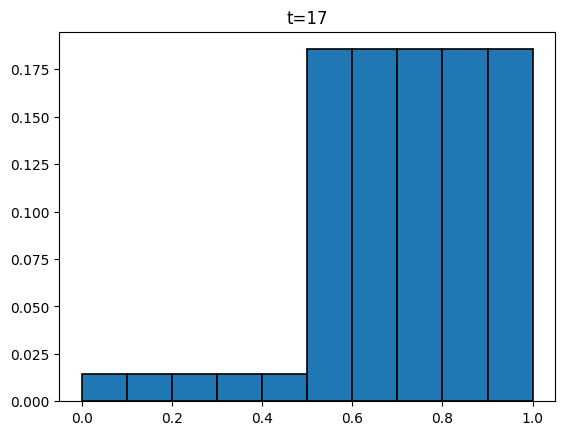

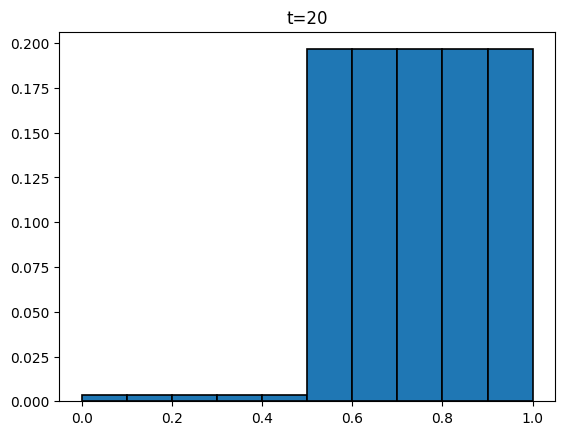

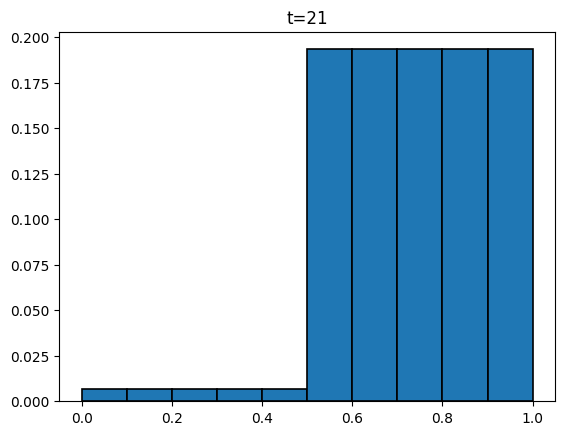

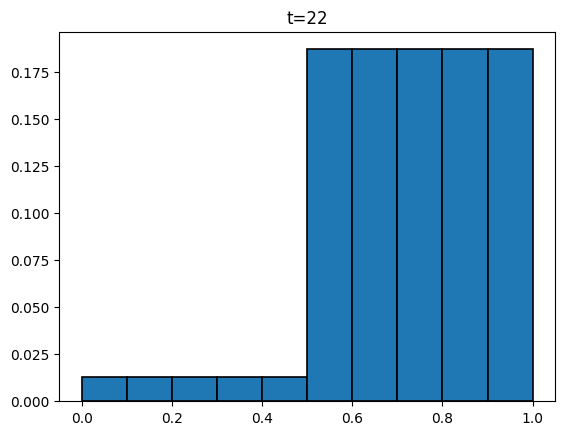

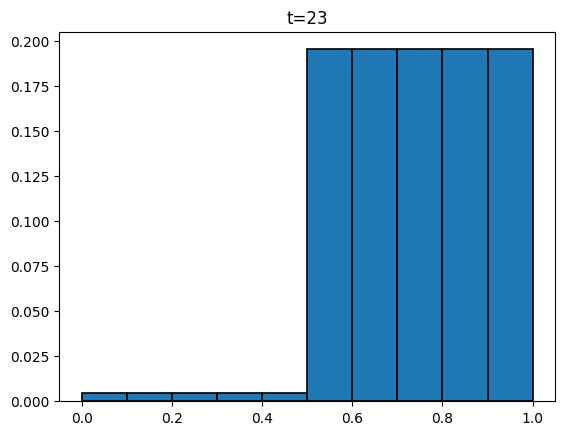

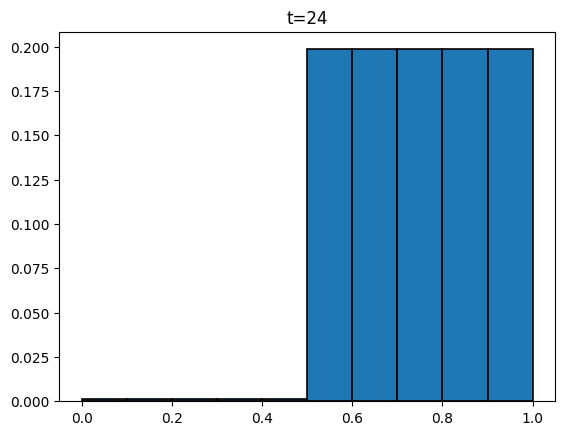

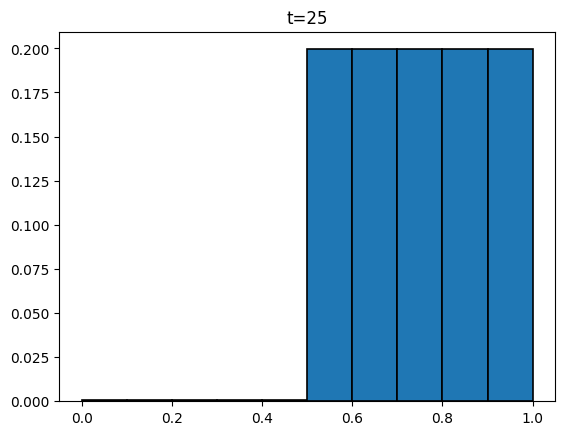

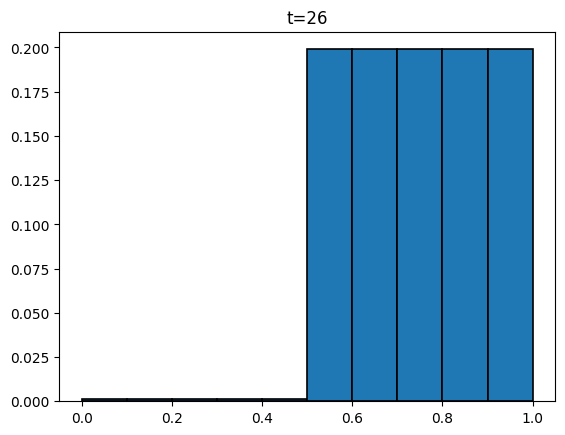

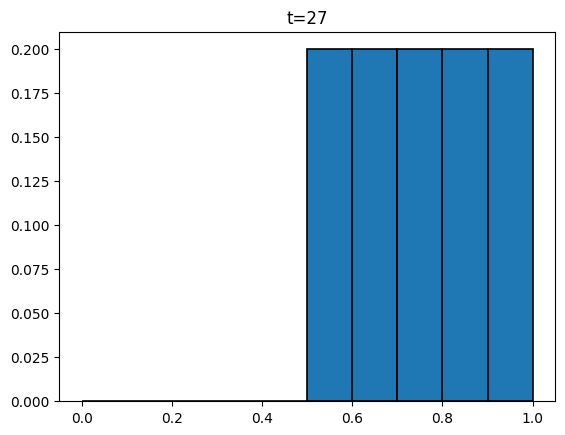

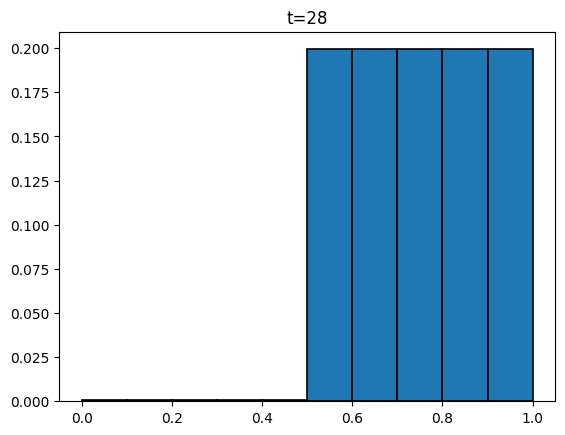

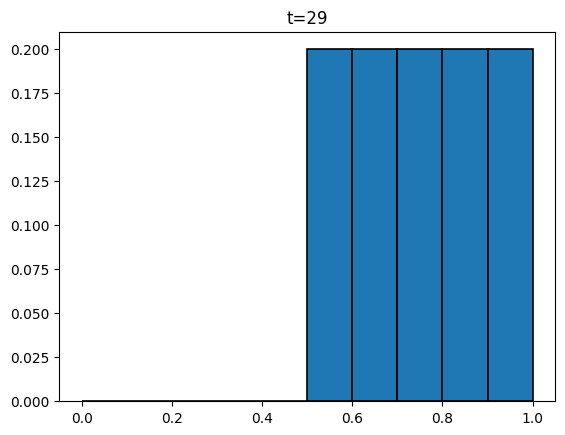

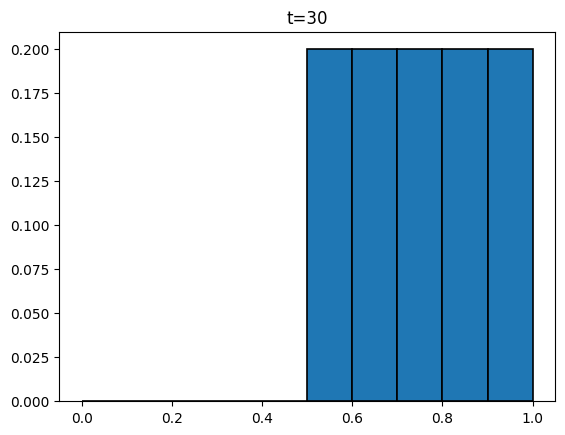

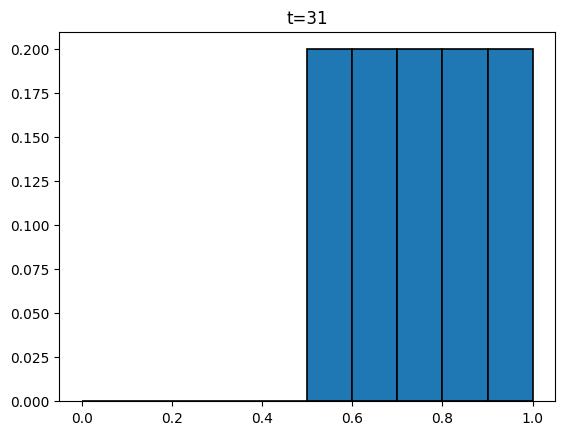

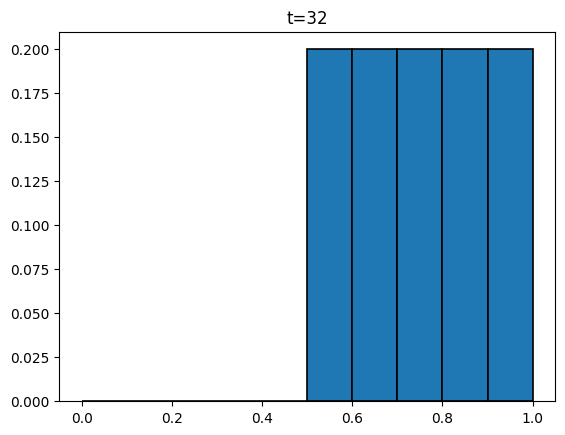

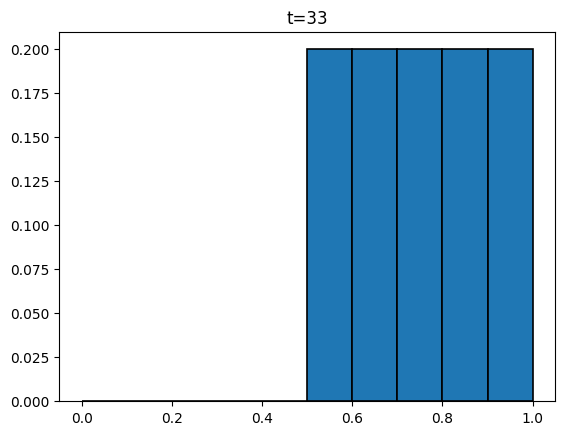

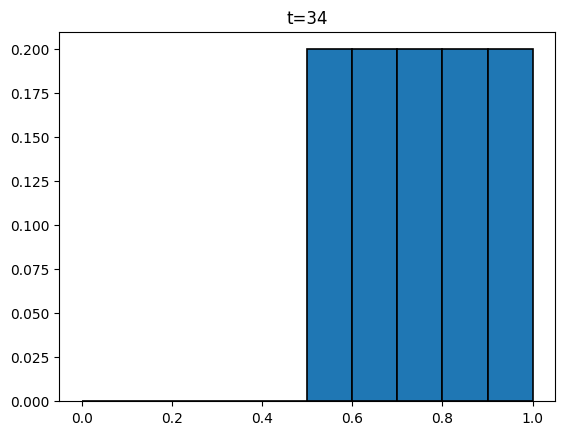

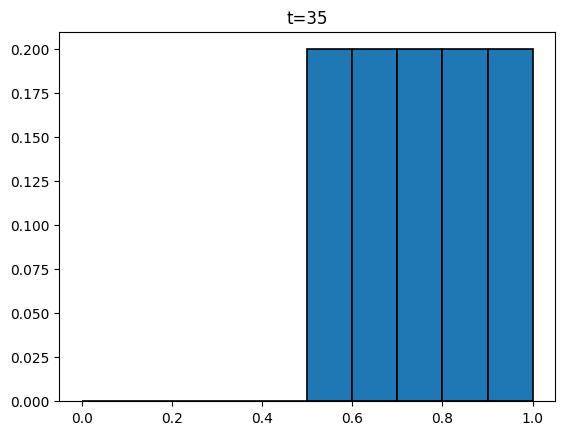

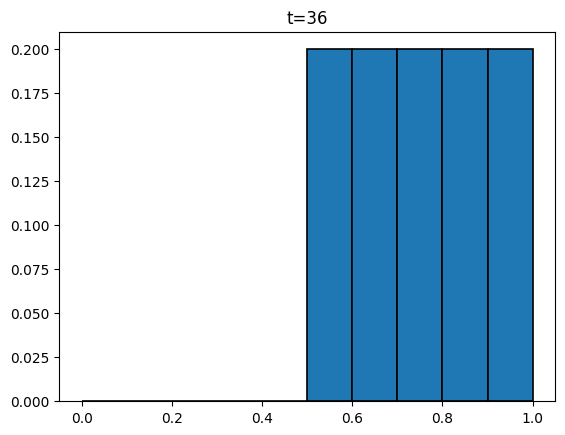

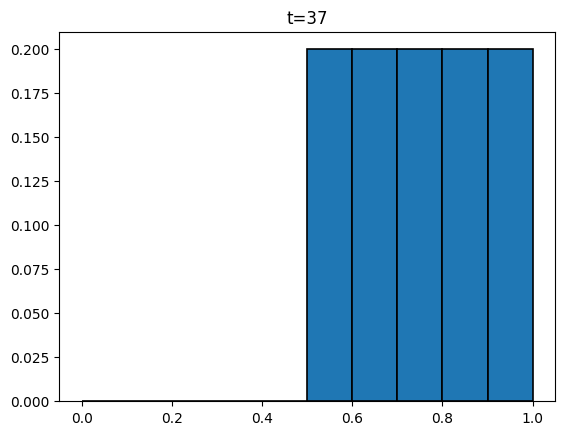

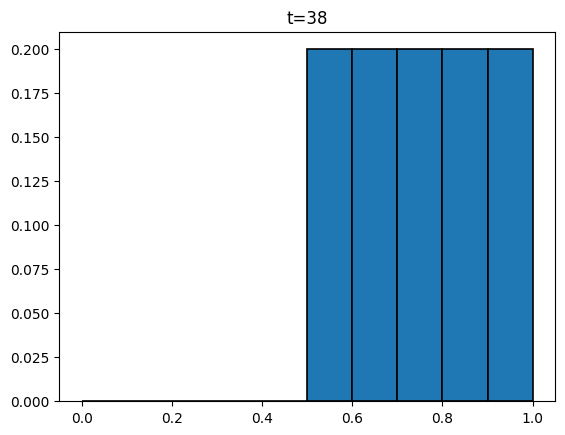

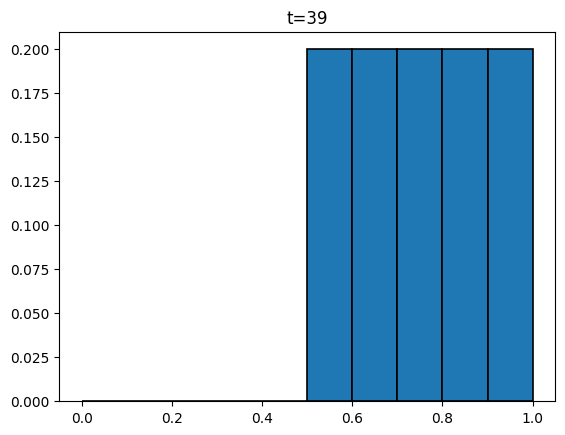

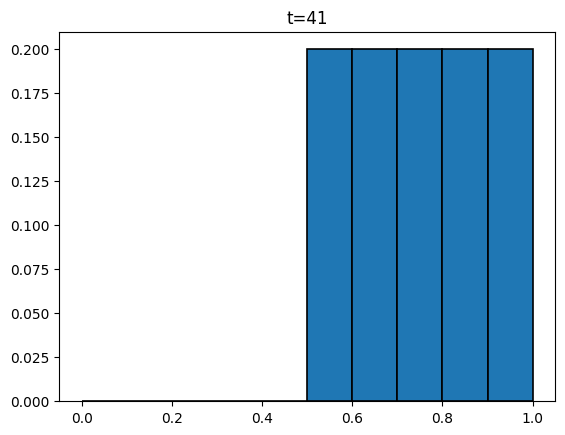

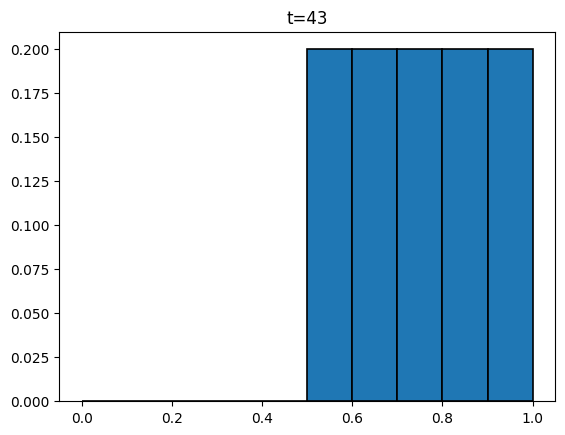

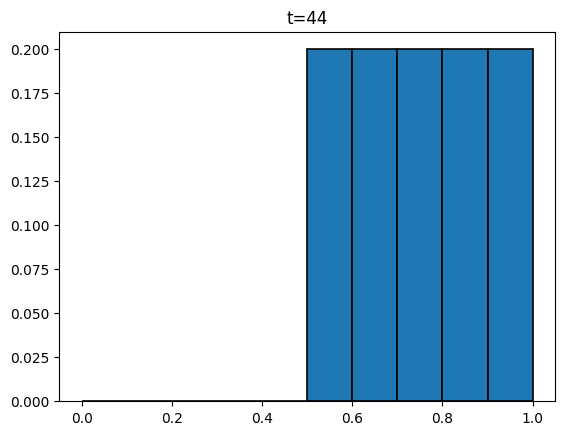

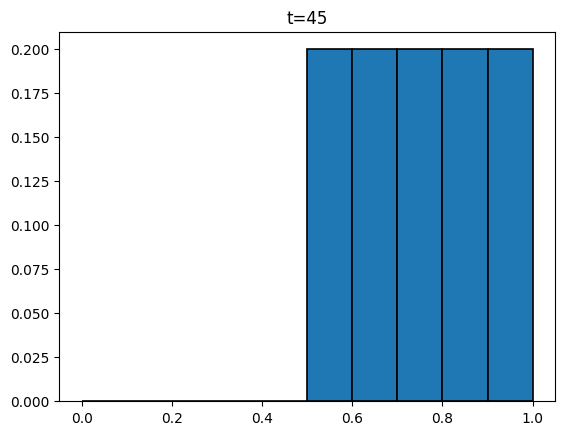

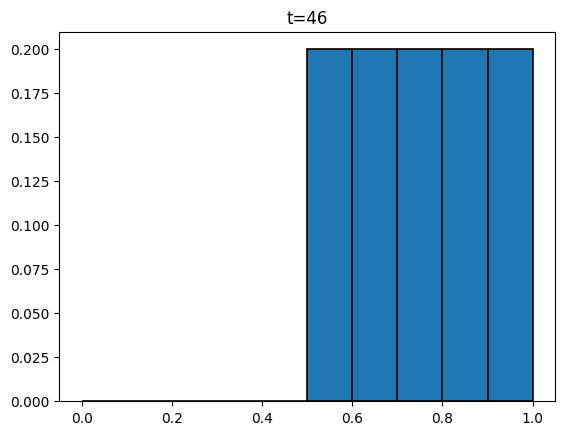

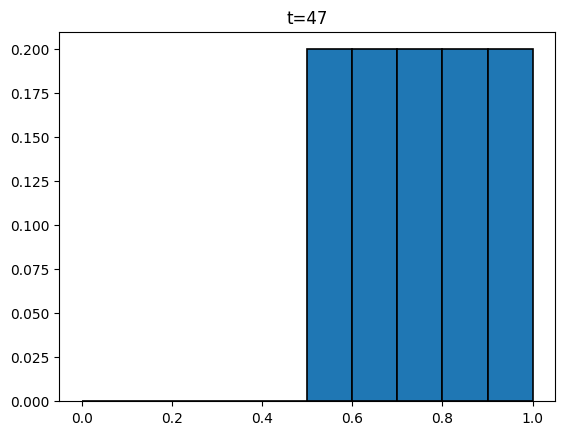

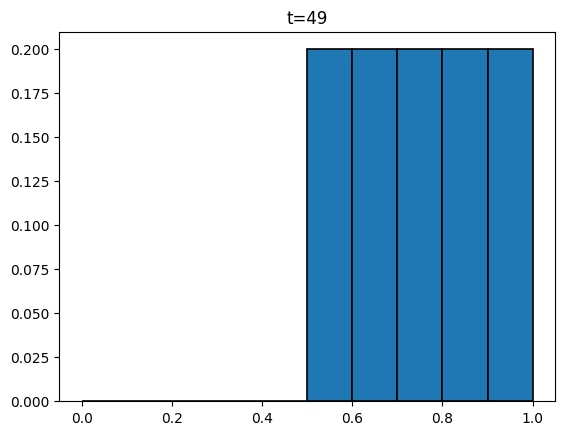

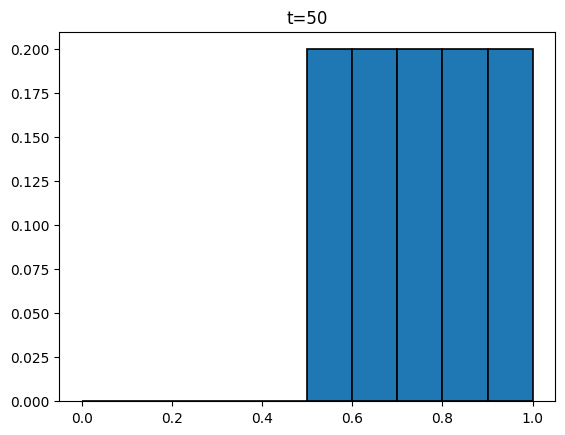

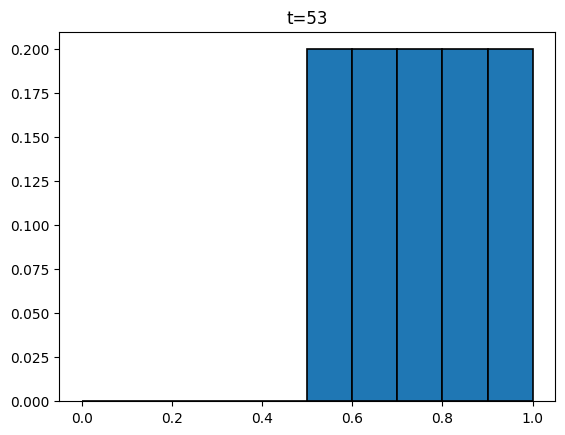

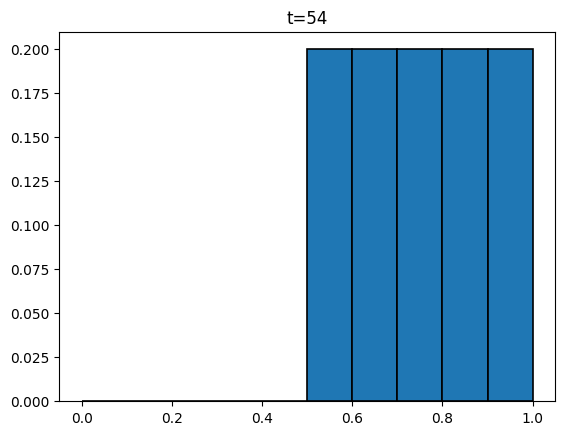

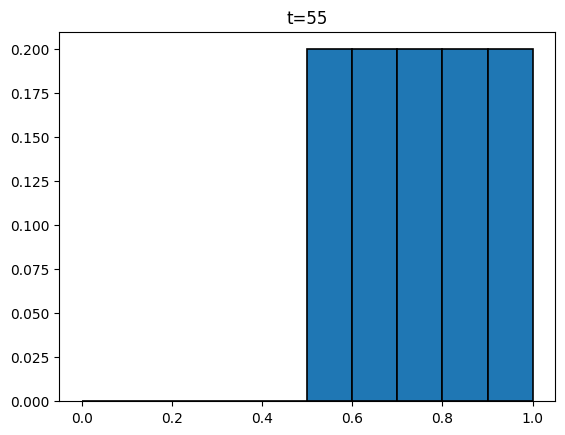

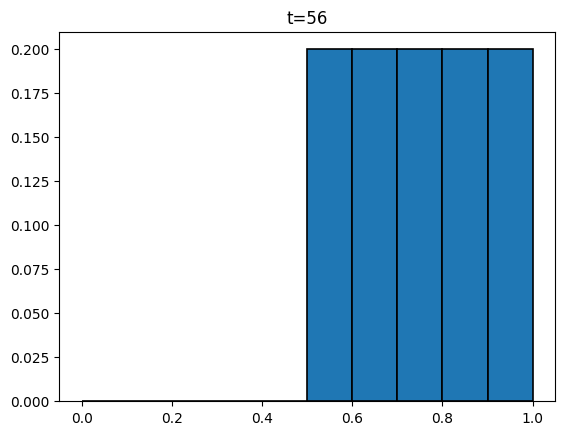

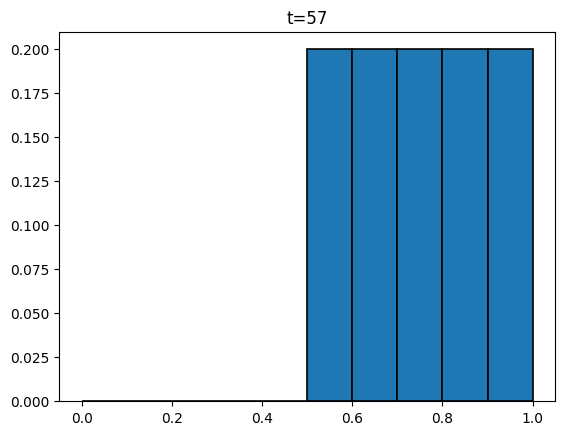

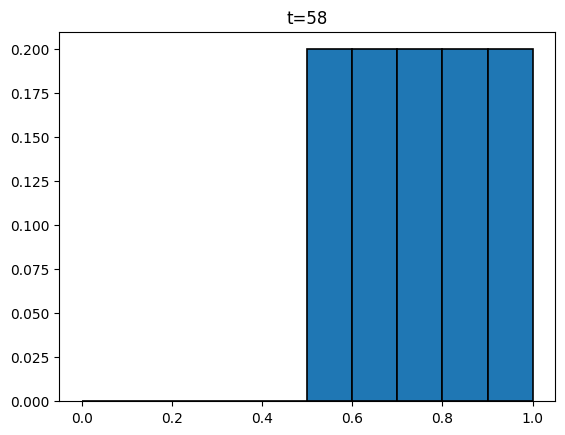

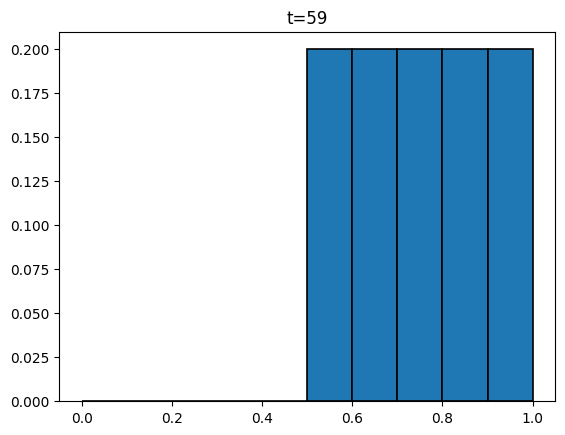

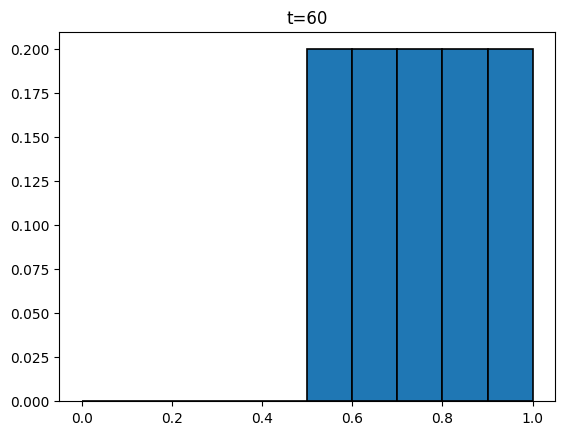

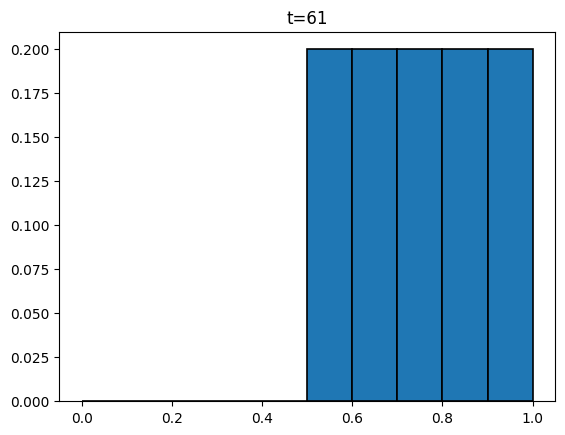

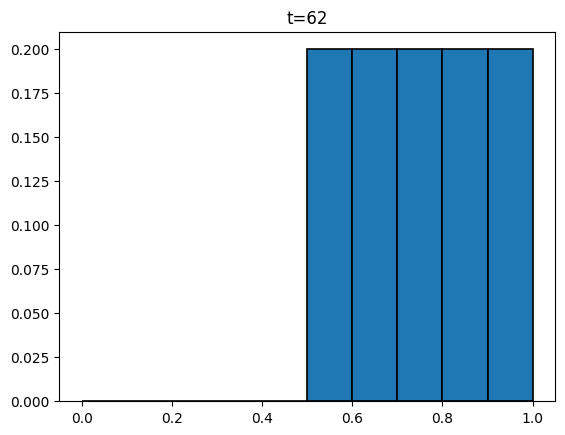

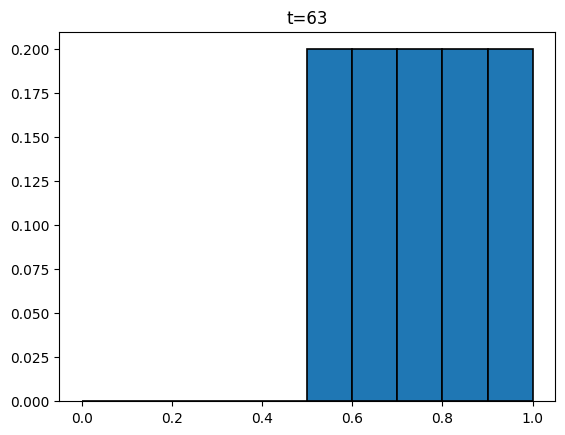

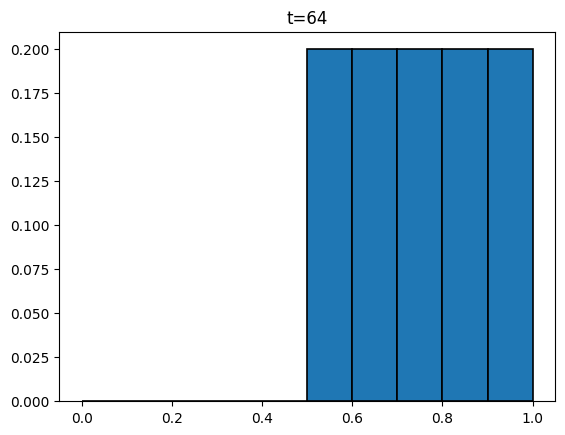

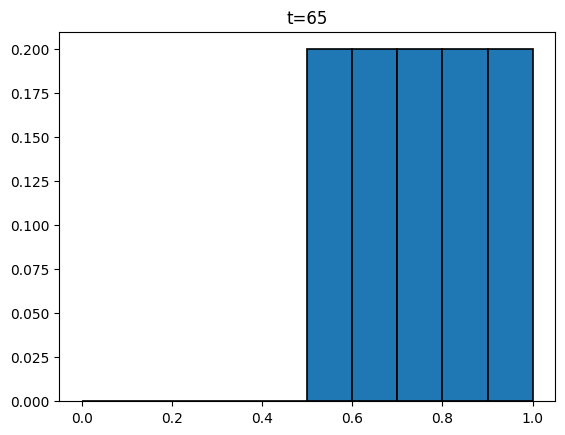

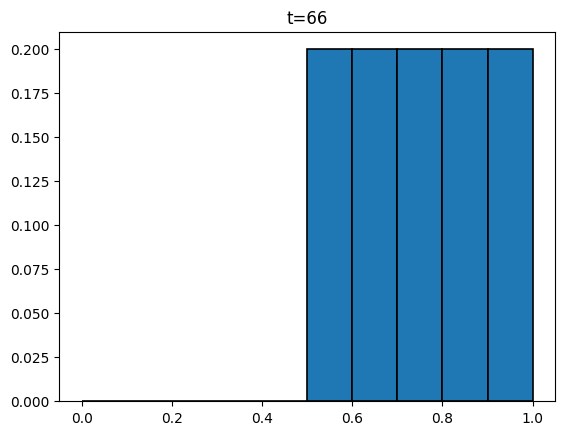

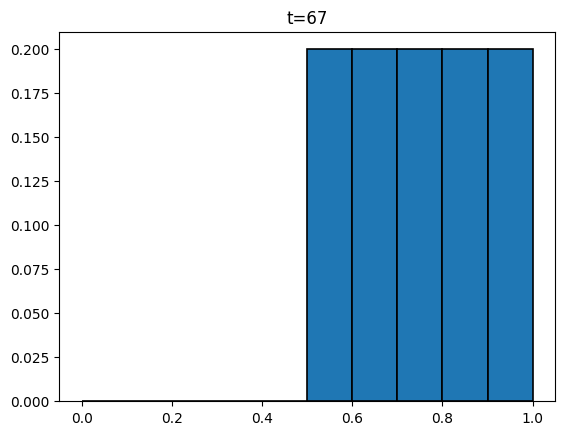

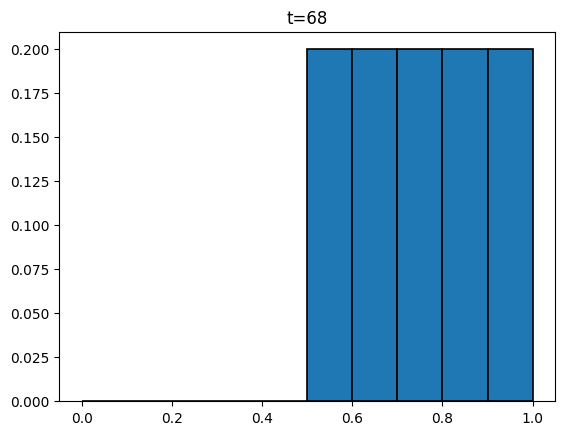

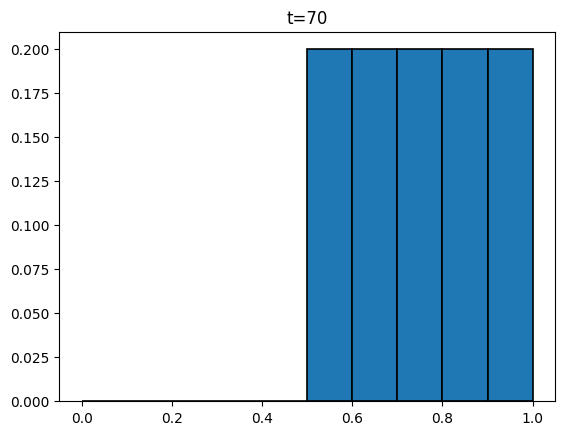

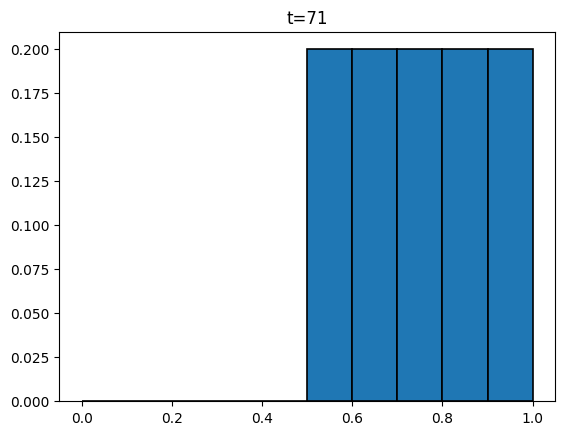

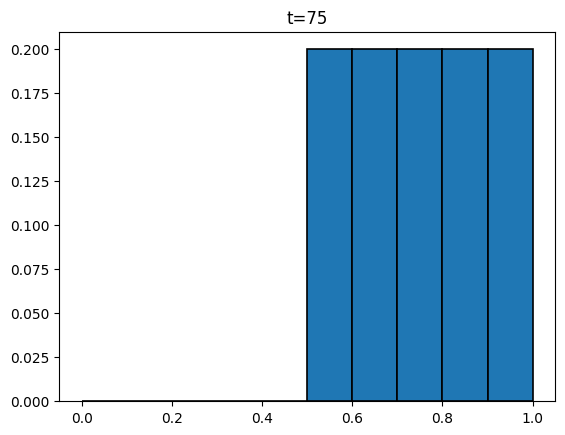

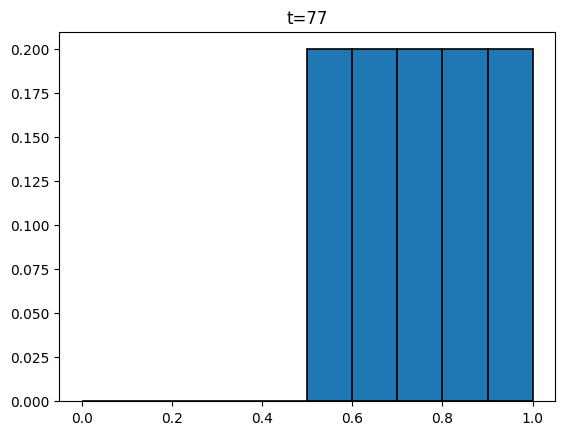

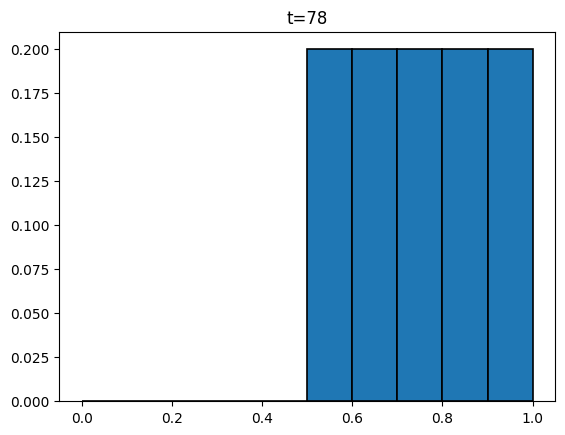

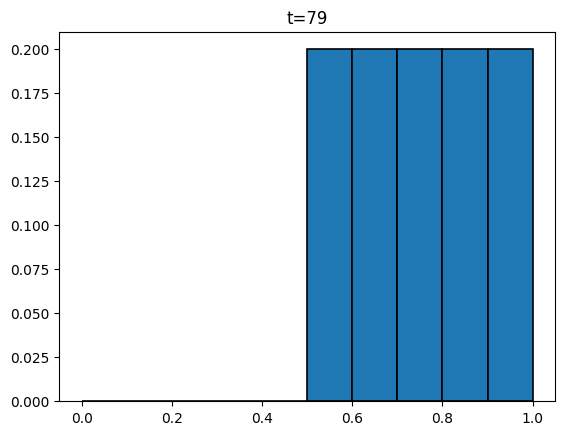

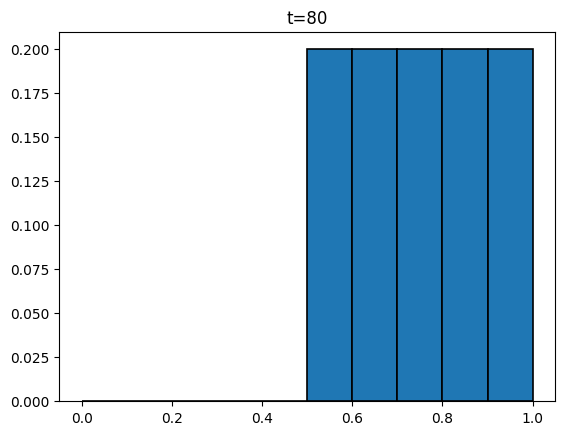

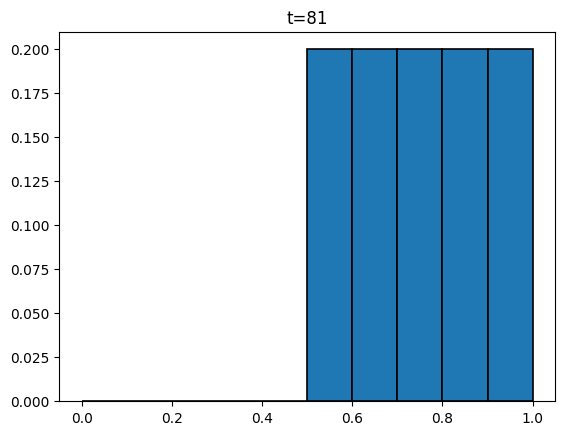

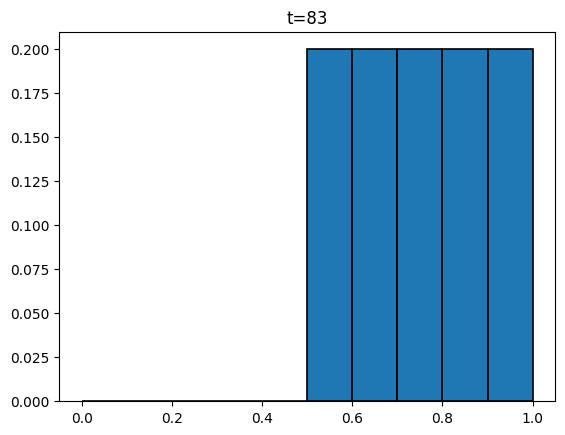

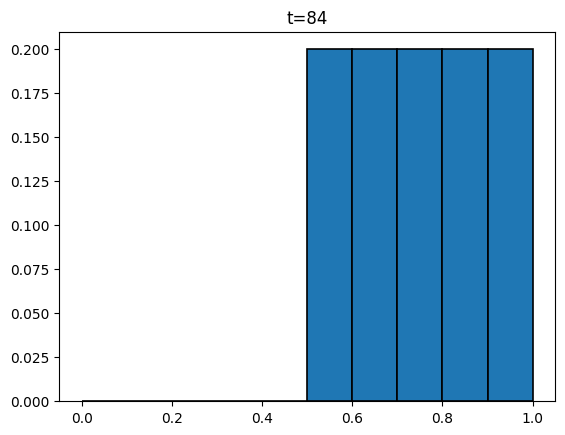

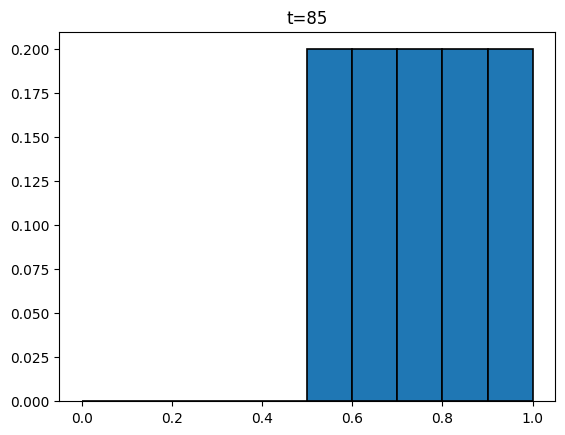

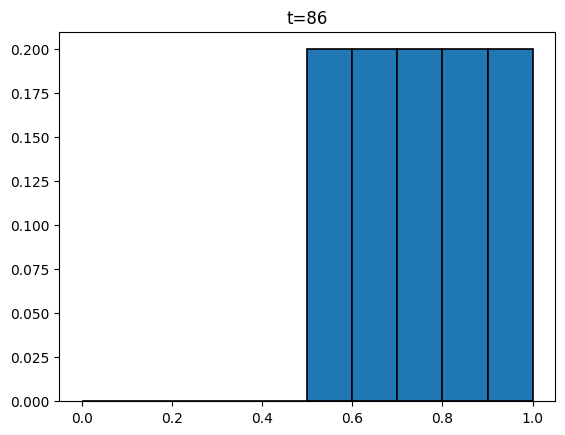

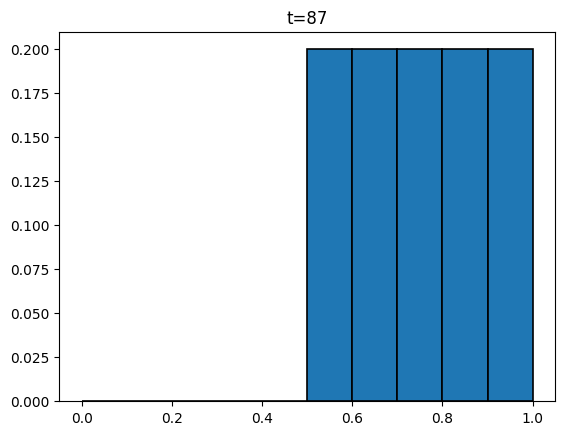

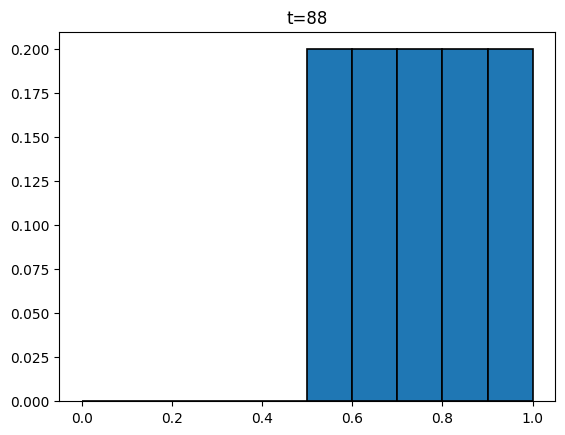

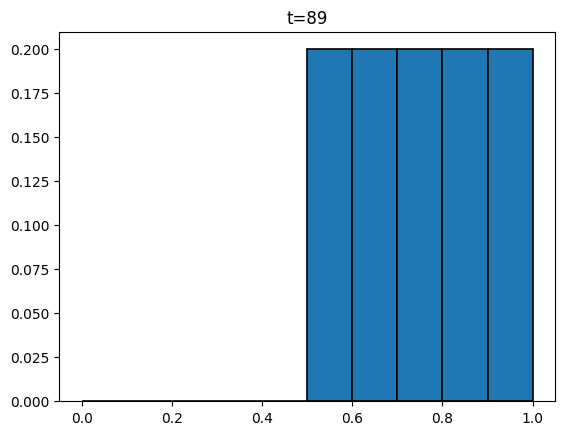

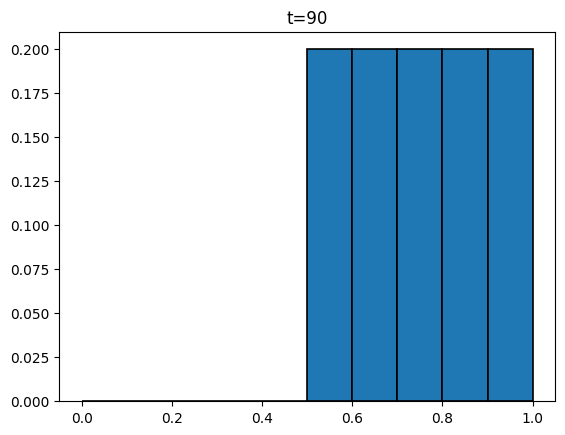

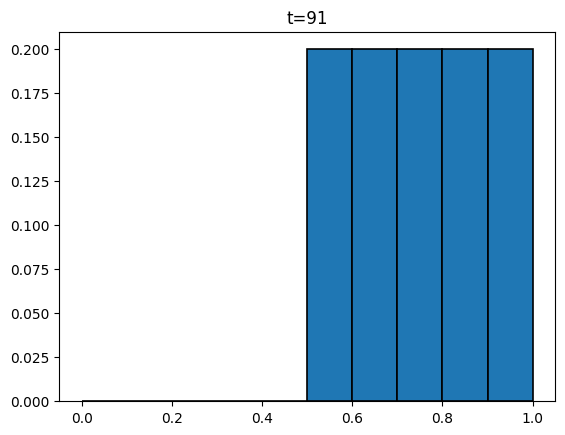

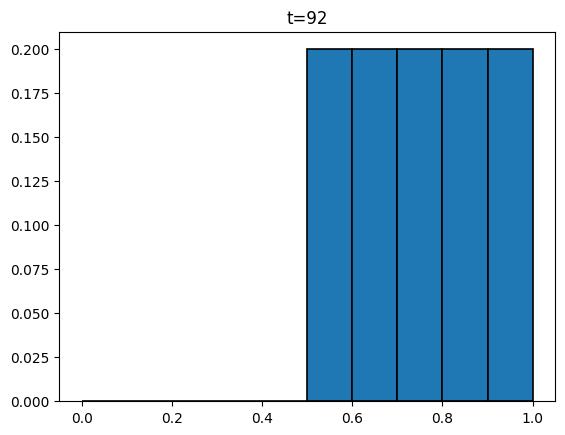

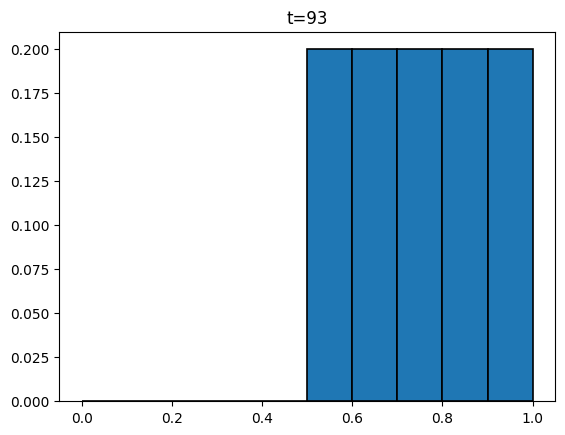

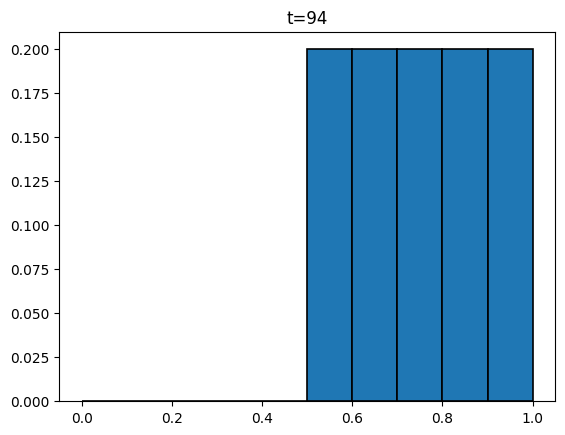

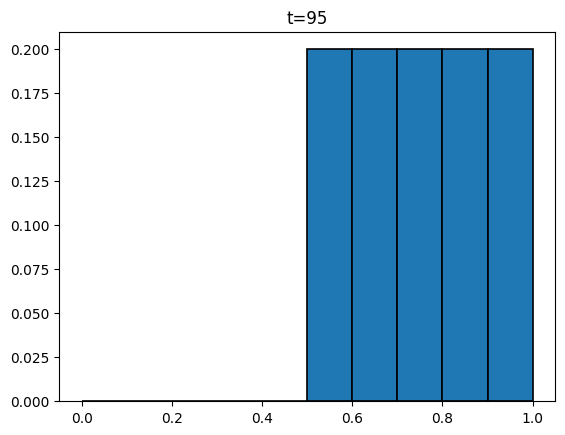

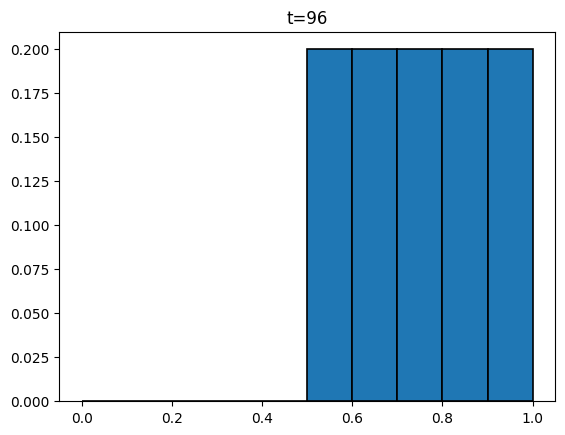

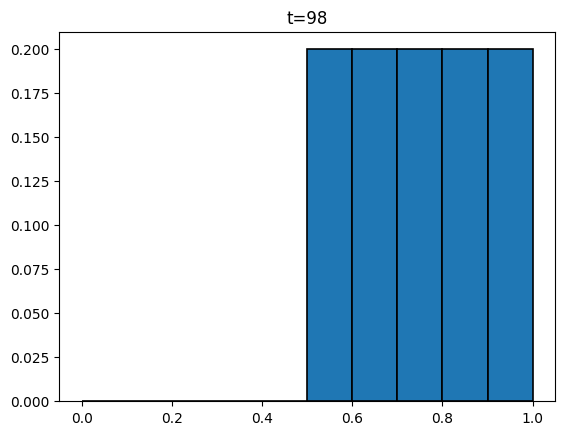

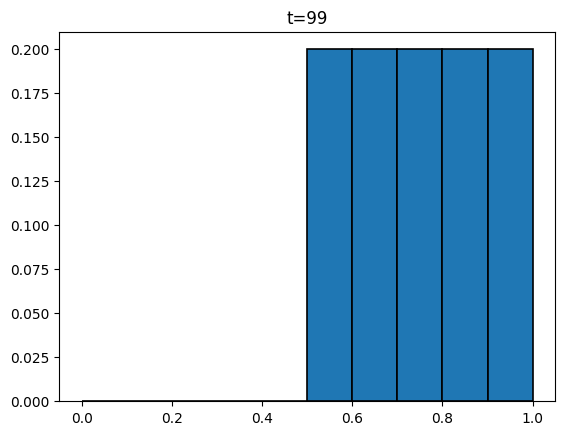

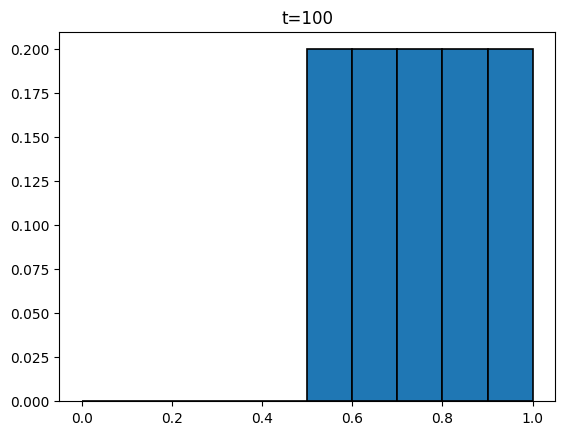

In [15]:
import copy

num_particles = 10
particles = np.linspace(0,1,num=num_particles) # particles representing the probability that the door is open
log_weights = [[np.log(1.0) for _ in range(num_particles)]] # we represent the weights as log(w) to avoid underflowing

for t in range(num_obs):
    lw = copy.deepcopy(log_weights[t])
    for m in range(num_particles):
        x = int(round(particles[m])) # 0 for closed, 1 for open
        pzx = obs_prob[x, obs[t]]
        lw[m] = lw[m] + np.log(pzx)
        # print(f"x: {x} z: {obs[t]} pzx: {pzx} lw: {lw[m]}")
    log_weights.append(lw)
        
weights = [np.exp(l) for l in log_weights[-1]]
s = np.sum(weights)
weights = np.array(weights)/s

print(f"Estimated prob. door is open: {np.dot(weights, particles)}")

# plot particle distribution for all time-steps
for t in range(len(log_weights)):
    # simulate new data coming in
    lw = log_weights[t]
    w = [np.exp(l) for l in lw]
    s = np.sum(w)
    w = np.array(w)/s

    plt.title(f"t={t}")
    plt.hist(particles, bins=len(particles), weights=w, edgecolor='black', linewidth=1.2)
    plt.show()